![slide1](selected_presentation_slides/slide1.png)

![slide2](selected_presentation_slides/slide2.png)

![slide3](selected_presentation_slides/slide3.png)

![slide4](selected_presentation_slides/slide4.png)

![slide5](selected_presentation_slides/slide5.png)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

D = 4 # fuselage diameter [m]
R = D/2 # fuselage radius [m]
M = 60e6 # bending moment [Nm]
V = 660e3 # shear force [N]
T = 30e3 # torsional moment [Nm]
theta_lower_limit = -15 # bank angle [degrees]
theta_upper_limit = 15 # bank angle [degrees]
theta_increment = 5 # increments of bank angle used in analysis [degrees]
theta_array = np.arange(theta_lower_limit, theta_upper_limit + theta_increment, theta_increment) # bank angles considered in analysis
rho_aluminium = 2800 # aluminium density [kg/m**3]
sigma_yield_aluminium = 483e6 # yield stress aluminium [Pa]
safety_factor = 1
sigma_z_max_allowed = sigma_yield_aluminium * safety_factor # maximum allowable stress for design [Pa]



#first approach, thin walled cylinder, t=constant
y2_max = R # maximum distance from the principal axis
t_min = M * y2_max / (np.pi * R**3 * sigma_z_max_allowed) # minimum thickness [m]
mass_per_unit_length = rho_aluminium * ( 2 * np.pi * R * t_min) # mass per unit length [kg/m]

print (f"The mass per unit length of the first design is {mass_per_unit_length} [kg/m]")

The mass per unit length of the first design is 347.82608695652175 [kg/m]


![slide6](selected_presentation_slides/slide6.png)

![slide7](selected_presentation_slides/slide7.png)

![slide8](selected_presentation_slides/slide8.png)

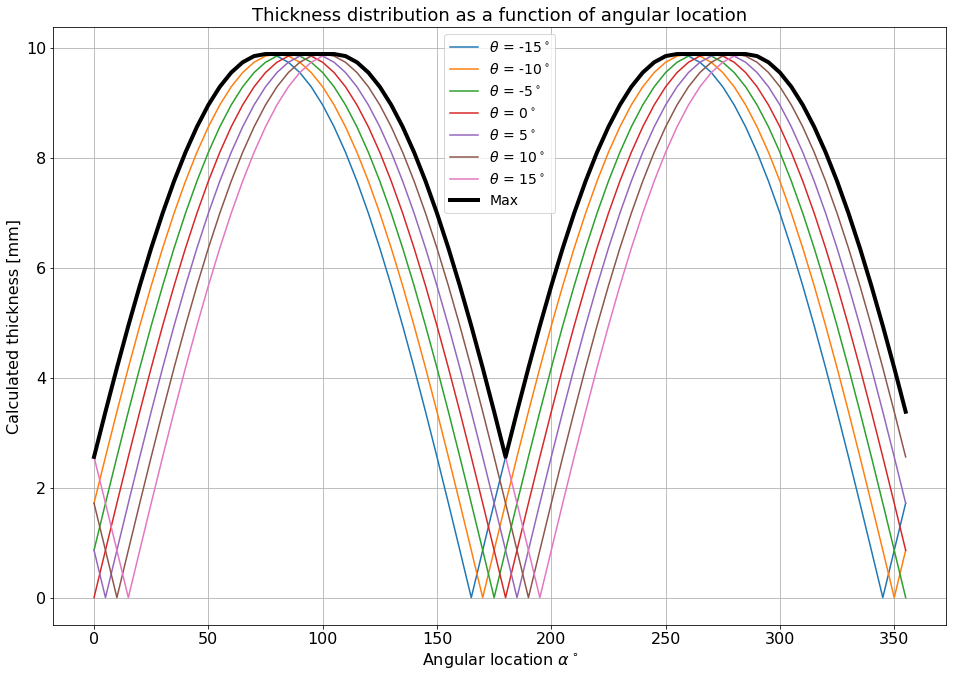

In [2]:
#second approach, thin walled cylinder, t = variable
alpha_min = 0 # angular location [degrees]
alpha_max = 360 # angular location [degrees]
alpha_increment = 5 # increments of angular location used in analysis [degrees]
alpha_array = np.arange(alpha_min, alpha_max, alpha_increment)

t_as_function_of_alhpha_array = np.zeros((theta_array.size, alpha_array.size))
for theta_idx, theta in enumerate(theta_array):
    t_as_function_of_alhpha = np.abs( M * np.sin(np.deg2rad(alpha_array - theta)) / ( np.pi * R**2 * sigma_z_max_allowed) )
    t_as_function_of_alhpha_array[theta_idx] = t_as_function_of_alhpha
    
t_max_as_function_of_alpha = np.amax(t_as_function_of_alhpha_array, axis=0) # noting the maximum thickness needed for design

fig, ax = plt.subplots(figsize=(16, 11))

for theta, t_as_function_of_alhpha in zip(theta_array, t_as_function_of_alhpha_array):
    plt.plot(alpha_array, t_as_function_of_alhpha * 1e3, label = rf"$\theta$ = {theta}$^\circ$")
plt.plot(alpha_array, t_max_as_function_of_alpha * 1e3, 'k-', linewidth = 4, label = "Max")
    
ax.set_title ("Thickness distribution as a function of angular location", fontsize = 18)
ax.set_xlabel (r"Angular location $\alpha^\circ$", fontsize = 16)
ax.set_ylabel ("Calculated thickness [mm]", fontsize = 16)
ax.tick_params (axis="both", which="major", labelsize=16)
plt.grid (axis="both")
plt.legend(fontsize = 14);

In [3]:
mass_per_unit_length = rho_aluminium * np.sum(t_max_as_function_of_alpha * np.deg2rad(alpha_increment) * R) # carrying out the integration
print (f"The mass per unit length of the second design is {mass_per_unit_length} [kg/m]")

The mass per unit length of the second design is 271.7230788647295 [kg/m]


![slide9](selected_presentation_slides/slide9.png)

![slide10](selected_presentation_slides/slide10.png)

![slide11](selected_presentation_slides/slide11.png)

In [4]:
#third approach, circular cross section build from plates of variable thickness

def sigma_z(M, y, I):
    """
    PARAMETERS
    ----------------
    M = bending moment
    y = distance from neutral axis
    I = second moment of area retlative to the neutral axis
    
    RETURNS
    ----------------
    Normal stress at the given y location according to the flexure formula
    """
    return M * y / I # flexure formula

def I_xx_angled_plate(L, t, beta, d):
    """
    PARAMETERS
    ----------------
    L = plate length [m]
    t = plate thickness [m]
    beta = plate angle w.r.t. principal X axis [deg]
    d = plate centroid distance from principal X axis [m]
    
    RETURNS
    ----------------
    Second moment of area of angled plate w.r.t. principal X axis [m**4]
    """
    return t * L**3 * np.sin(beta)**2 / 12 + t * L * d**2

def I_yy_angled_plate(L, t, beta, d):
    """
    PARAMETERS
    ----------------
    L = plate length [m]
    t = plate thickness [m]
    beta = plate angle w.r.t. principal X axis [deg]
    d = plate centroid distance from principal Y axis [m]
    
    RETURNS
    ----------------
    Second moment of area of angled plate w.r.t. principal Y axis [m**4]
    """
    return t * L**3 * np.cos(beta)**2 / 12 + t * L * d**2

M_x_array = M * np.cos(np.deg2rad(theta_array)) # moments along the principal X axis due to bank angle
M_y_array = M * np.sin(np.deg2rad(theta_array)) # moments along the principal Y axis due to bank angle

nr_plates = alpha_array.size
points_on_cross_section_X1_coordinates = R * np.cos(np.deg2rad( (alpha_array + alpha_increment/2)) ) # adding alpha_increment/2 to get the location of the centroid of each plate
points_on_cross_section_Y1_coordinates = R * np.sin(np.deg2rad( (alpha_array + alpha_increment/2)) ) # adding alpha_increment/2 to get the location of the centroid of each plate

max_iter = 1e2
iter_nr = 0

convergeance_achieved = False
I_xx_fuselage = 0
I_yy_fuselage = 0
angled_plates_thicknesses = t_max_as_function_of_alpha # start optimization from the previous thickness distribution
angled_plate_length = np.deg2rad(alpha_increment) * R # length of each fuselage segment approximated as a flat angled plate

#lists to store iteration results for later plotting
sigma_z_plates_as_function_of_theta_list = [] # will store the stress for each plate at each iteration in this list
angled_plates_thicknesses_list = [] # will store the thickness calculated for each plate at the end of each iteration in this list

while not convergeance_achieved and iter_nr < max_iter:
    for t, alpha in zip(angled_plates_thicknesses, alpha_array):
        I_xx_fuselage += I_xx_angled_plate( angled_plate_length, t, alpha + 90, R * np.sin(np.deg2rad(alpha)) )
        I_yy_fuselage += I_yy_angled_plate( angled_plate_length, t, alpha + 90, R * np.cos(np.deg2rad(alpha)) )

    sigma_z_plates_as_function_of_theta = np.zeros((theta_array.size, nr_plates)) # to store the sigma_z values for each plate for each bank angle considered
    # allows for many plots to be created to study the evolution of stress distribution during optimization
    
    for theta_idx, (theta, M_x, M_y) in enumerate( zip(theta_array, M_x_array, M_y_array) ):
        for point_idx, (X1_coord, Y1_coord) in enumerate( zip(points_on_cross_section_X1_coordinates, points_on_cross_section_Y1_coordinates) ):
            sigma_z_plates_as_function_of_theta[theta_idx, point_idx]  = sigma_z(M_x, Y1_coord, I_xx_fuselage) - sigma_z(M_y, X1_coord, I_yy_fuselage)
            
    sigma_z_plates_as_function_of_theta_list.append(sigma_z_plates_as_function_of_theta) # storing stress results for this iteration
    angled_plates_thicknesses_list.append(angled_plates_thicknesses) # storing plate thicknesses for this iteration
    
    sigma_z_plates_max = np.max( np.abs(sigma_z_plates_as_function_of_theta), axis = 0 ) # taking the maximum absulute stress calculated at the centroid of each plate for all bank angles
    sigma_z_factor_plates = sigma_z_plates_max / sigma_z_max_allowed
    

    if 0.92 < sigma_z_factor_plates.all() < 0.99:
        convergeance_achieved = True
    else:
        I_xx_fuselage = 0
        I_yy_fuselage = 0
        angled_plates_thicknesses = sigma_z_factor_plates * angled_plates_thicknesses
        
    iter_nr += 1

if convergeance_achieved:
    print ("Convergence was achieved!")
else:
    print ("Maximum number of iterations allowed was exceeded!")

Maximum number of iterations allowed was exceeded!


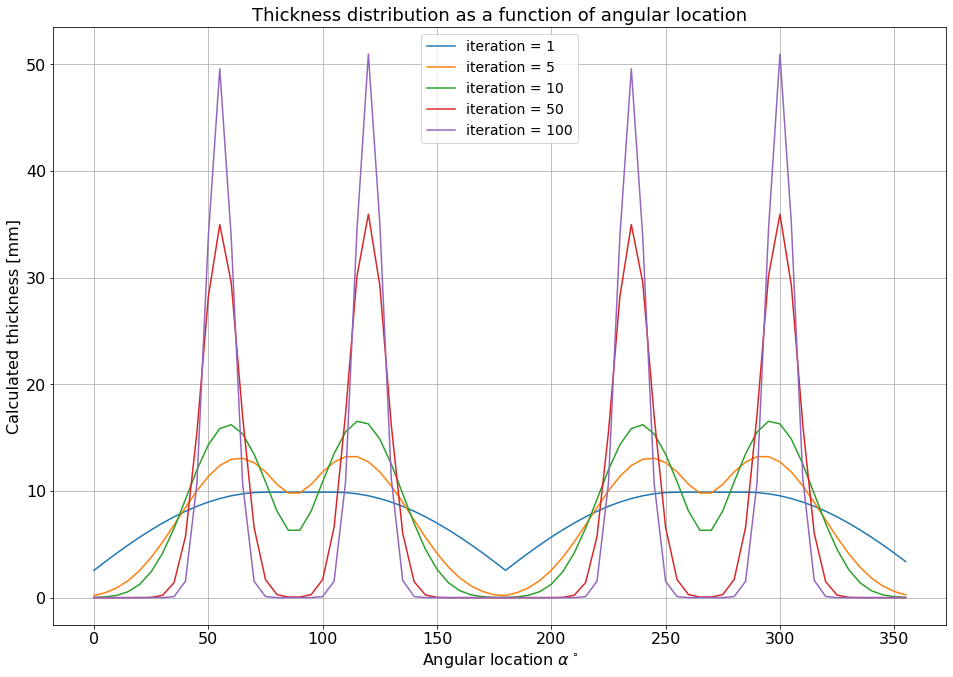

In [5]:
iterations_to_plot = [1, 5, 10, 50, 100] # will substract 1 when indexing because indexing starts at 0 in Python
fig, ax = plt.subplots(figsize=(16,11))

for iteration_nr in iterations_to_plot:
    plt.plot(alpha_array, angled_plates_thicknesses_list[iteration_nr - 1] * 1e3, label = f"iteration = {iteration_nr}")
    
ax.set_title ("Thickness distribution as a function of angular location", fontsize = 18)
ax.set_xlabel (r"Angular location $\alpha^\circ$", fontsize = 16)
ax.set_ylabel ("Calculated thickness [mm]", fontsize = 16)
ax.tick_params (axis="both", which="major", labelsize=16)
plt.grid (axis="both")
plt.legend(fontsize = 14);

In [6]:
mass_per_unit_length = rho_aluminium * np.sum(angled_plates_thicknesses * angled_plate_length) # carrying out the integration
print (f"The mass per unit length of the third design is {mass_per_unit_length} [kg/m]")

The mass per unit length of the third design is 281.3659849473734 [kg/m]


![slide12](selected_presentation_slides/slide12.png)